# Customer Support

Here, we show an example of building a customer support chatbot.

This customer support chatbot interacts with SQL database to answer questions.
We will use a mock SQL database to get started: the [Chinook](https://www.sqlitetutorial.net/sqlite-sample-database/) database.
This database is about sales from a music store: what songs and album exists, customer orders, things like that.

This chatbot has two different states:
1. Music: the user can inquire about different songs and albums present in the store
2. Account: the user can ask questions about their account

Under the hood, this is handled by two separate agents.
Each has a specific prompt and tools related to their objective.
There is also a generic agent who is responsible for routing between these two agents as needed.

Note: This is a very simple example! For a more complete tutorial on building a customer support bot, check out the [Customer Support Tutorial](../customer-support/customer-support.ipynb) for more information.

In [3]:
%%capture --no-stderr
%pip install -U langchain-community langchain-openai scikit-learn

In [4]:
#!pip uninstall langgraph
!pip install langgraph==0.1.17

Found existing installation: langgraph 0.1.17
Uninstalling langgraph-0.1.17:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/langgraph-0.1.17.dist-info/*
    /usr/local/lib/python3.10/dist-packages/langgraph/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/langgraph/checkpoint/base/__init__.py
    /usr/local/lib/python3.10/dist-packages/langgraph/checkpoint/base/id.py
    /usr/local/lib/python3.10/dist-packages/langgraph/checkpoint/py.typed
    /usr/local/lib/python3.10/dist-packages/langgraph/checkpoint/serde/__init__.py
    /usr/local/lib/python3.10/dist-packages/langgraph/checkpoint/serde/base.py
    /usr/local/lib/python3.10/dist-packages/langgraph/checkpoint/serde/jsonplus.py
    /usr/local/lib/python3.10/dist-packages/langgraph/checkpoint/serde/types.py
Proceed (Y/n)? Y
  Successfully uninstalled langgraph-0.1.17
  Using cached langgraph-0.1.17-py3-none-any.whl.metadata (13 kB)
Using cached langgraph-0.1.17-py3-none-any.whl (

## Load the data

In [5]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"
response = requests.get(url)

with open("Chinook.db", "wb") as file:
    file.write(response.content)

In [6]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
db.get_usable_table_names()

['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']

## Load an LLM

We will load a language model to use.
For this demo we will use OpenAI.

In [7]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [8]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")

## Load Other Modules

Load other modules we will use.

All of the tools our agents will use will be custom tools. As such, we will use the `@tool` decorator to create custom tools.

We will pass in messages to the agent, so we load `HumanMessage` and `SystemMessage`

In [9]:
from langchain_core.messages import HumanMessage, SystemMessage

## Define the Customer Agent

This agent is responsible for looking up customer information.
It will have a specific prompt as well a specific tool to look up information about that customer (after asking for their user id).

In [10]:
# This tool is given to the agent to look up information about a customer
def get_customer_info(customer_id: int):
    """Look up customer info given their ID. ALWAYS make sure you have the customer ID before invoking this."""
    return db.run(f"SELECT * FROM Customer WHERE CustomerID = {customer_id};")

In [11]:
customer_prompt = """Your job is to help a user update their profile.

You only have certain tools you can use. These tools require specific input. If you don't know the required input, then ask the user for it.

If you are unable to help the user, you can """


def get_customer_messages(messages):
    return [SystemMessage(content=customer_prompt)] + messages


customer_chain = get_customer_messages | model.bind_tools([get_customer_info])

## Define the Music Agent

This agent is responsible for figuring out information about music. To do that, we will create a prompt and various tools for looking up information about music

First, we will create indexes for looking up artists and track names.
This will allow us to look up artists and tracks without having to spell their names exactly right.

In [12]:
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings

artists = db._execute("select * from Artist")
songs = db._execute("select * from Track")
artist_retriever = SKLearnVectorStore.from_texts(
    [a["Name"] for a in artists], OpenAIEmbeddings(), metadatas=artists
).as_retriever()
song_retriever = SKLearnVectorStore.from_texts(
    [a["Name"] for a in songs], OpenAIEmbeddings(), metadatas=songs
).as_retriever()

First, let's create a tool for getting albums by artist.

In [13]:
def get_albums_by_artist(artist):
    """Get albums by an artist (or similar artists)."""
    docs = artist_retriever.get_relevant_documents(artist)
    artist_ids = ", ".join([str(d.metadata["ArtistId"]) for d in docs])
    return db.run(
        f"SELECT Title, Name FROM Album LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Album.ArtistId in ({artist_ids});",
        include_columns=True,
    )

Next, lets create a tool for getting tracks by an artist

In [14]:
def get_tracks_by_artist(artist):
    """Get songs by an artist (or similar artists)."""
    docs = artist_retriever.invoke(artist)
    artist_ids = ", ".join([str(d.metadata["ArtistId"]) for d in docs])
    return db.run(
        f"SELECT Track.Name as SongName, Artist.Name as ArtistName FROM Album LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId LEFT JOIN Track ON Track.AlbumId = Album.AlbumId WHERE Album.ArtistId in ({artist_ids});",
        include_columns=True,
    )

Finally, let's create a tool for looking up songs by their name.

In [15]:
def check_for_songs(song_title):
    """Check if a song exists by its name."""
    return song_retriever.invoke(song_title)

Create the chain to call the relevant tools

In [16]:
song_system_message = """Your job is to help a customer find any songs they are looking for.

You only have certain tools you can use. If a customer asks you to look something up that you don't know how, politely tell them what you can help with.

When looking up artists and songs, sometimes the artist/song will not be found. In that case, the tools will return information \
on similar songs and artists. This is intentional, it is not the tool messing up."""


def get_song_messages(messages):
    return [SystemMessage(content=song_system_message)] + messages


song_recc_chain = get_song_messages | model.bind_tools(
    [get_albums_by_artist, get_tracks_by_artist, check_for_songs]
)

In [17]:
msgs = [HumanMessage(content="hi! can you help me find songs by amy whinehouse?")]
song_recc_chain.invoke(msgs)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_LwaKrSPFpznpQxdj43TB4jVw', 'function': {'arguments': '{"artist":"amy whinehouse"}', 'name': 'get_tracks_by_artist'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a'}, id='run-ba61b730-a4b6-4f6b-9de6-34540dc030fb-0', tool_calls=[{'name': 'get_tracks_by_artist', 'args': {'artist': 'amy whinehouse'}, 'id': 'call_LwaKrSPFpznpQxdj43TB4jVw', 'type': 'tool_call'}])

## Define the Generic Agent

We now define a generic agent that is responsible for handling initial inquiries and routing to the right sub agent.

In [18]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.pydantic_v1 import BaseModel, Field


class Router(BaseModel):
    """Call this if you are able to route the user to the appropriate representative."""

    choice: str = Field(description="should be one of: music, customer")


system_message = """Your job is to help as a customer service representative for a music store.

You should interact politely with customers to try to figure out how you can help. You can help in a few ways:

- Updating user information: if a customer wants to update the information in the user database. Call the router with `customer`
- Recommending music: if a customer wants to find some music or information about music. Call the router with `music`

If the user is asking or wants to ask about updating or accessing their information, send them to that route.
If the user is asking or wants to ask about music, send them to that route.
Otherwise, respond."""


def get_messages(messages):
    return [SystemMessage(content=system_message)] + messages

In [19]:
chain = get_messages | model.bind_tools([Router])

In [20]:
msgs = [HumanMessage(content="hi! can you help me find a good song?")]
chain.invoke(msgs)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_KM121JfQmmfIW17Jy9HrjvjQ', 'function': {'arguments': '{"choice":"music"}', 'name': 'Router'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a'}, id='run-ddd7bced-b27b-4c04-b134-08034fc681d9-0', tool_calls=[{'name': 'Router', 'args': {'choice': 'music'}, 'id': 'call_KM121JfQmmfIW17Jy9HrjvjQ', 'type': 'tool_call'}])

In [21]:
msgs = [HumanMessage(content="hi! what's the email you have for me?")]
chain.invoke(msgs)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_7wNRuRunk6JAN6Q720c3qQjx', 'function': {'arguments': '{"choice":"customer"}', 'name': 'Router'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a'}, id='run-4a8e80a2-7f4f-48a2-9fa1-7e9fe9d4e252-0', tool_calls=[{'name': 'Router', 'args': {'choice': 'customer'}, 'id': 'call_7wNRuRunk6JAN6Q720c3qQjx', 'type': 'tool_call'}])

In [22]:
from langchain_core.messages import AIMessage


def add_name(message, name):
    _dict = message.dict()
    _dict["name"] = name
    return AIMessage(**_dict)

In [23]:
import json

from langgraph.graph import END, START


def _get_last_ai_message(messages):
    for m in messages[::-1]:
        if isinstance(m, AIMessage):
            return m
    return None


def _is_tool_call(msg):
    return hasattr(msg, "additional_kwargs") and "tool_calls" in msg.additional_kwargs


def _route(messages):
    last_message = messages[-1]
    if isinstance(last_message, AIMessage):
        if not last_message.tool_calls:
            return END
        else:
            if last_message.name == "general":
                if len(last_message.tool_calls) > 1:
                    raise ValueError("Too many tools")
                return last_message.tool_calls[0]["args"]["choice"]
            else:
                return "tools"
    last_m = _get_last_ai_message(messages)
    if last_m is None:
        return "general"
    if last_m.name == "music":
        return "music"
    elif last_m.name == "customer":
        return "customer"
    else:
        return "general"

In [24]:
from langgraph.prebuilt import ToolNode

tools = [get_albums_by_artist, get_tracks_by_artist, check_for_songs, get_customer_info]
tool_node = ToolNode(tools)

In [25]:
def _filter_out_routes(messages):
    ms = []
    for m in messages:
        if _is_tool_call(m):
            if m.name == "general":
                continue
        ms.append(m)
    return ms

In [26]:
from functools import partial

general_node = _filter_out_routes | chain | partial(add_name, name="general")
music_node = _filter_out_routes | song_recc_chain | partial(add_name, name="music")
customer_node = _filter_out_routes | customer_chain | partial(add_name, name="customer")

In [27]:
from langgraph.checkpoint.sqlite import SqliteSaver

from langgraph.graph import MessageGraph

memory = SqliteSaver.from_conn_string(":memory:")
graph = MessageGraph()
nodes = {
    "general": "general",
    "music": "music",
    END: END,
    "tools": "tools",
    "customer": "customer",
}
# Define a new graph
workflow = MessageGraph()
workflow.add_node("general", general_node)
workflow.add_node("music", music_node)
workflow.add_node("customer", customer_node)
workflow.add_node("tools", tool_node)
workflow.add_conditional_edges("general", _route, nodes)
workflow.add_conditional_edges("tools", _route, nodes)
workflow.add_conditional_edges("music", _route, nodes)
workflow.add_conditional_edges("customer", _route, nodes)
workflow.add_conditional_edges(START, _route, nodes)
graph = workflow.compile()

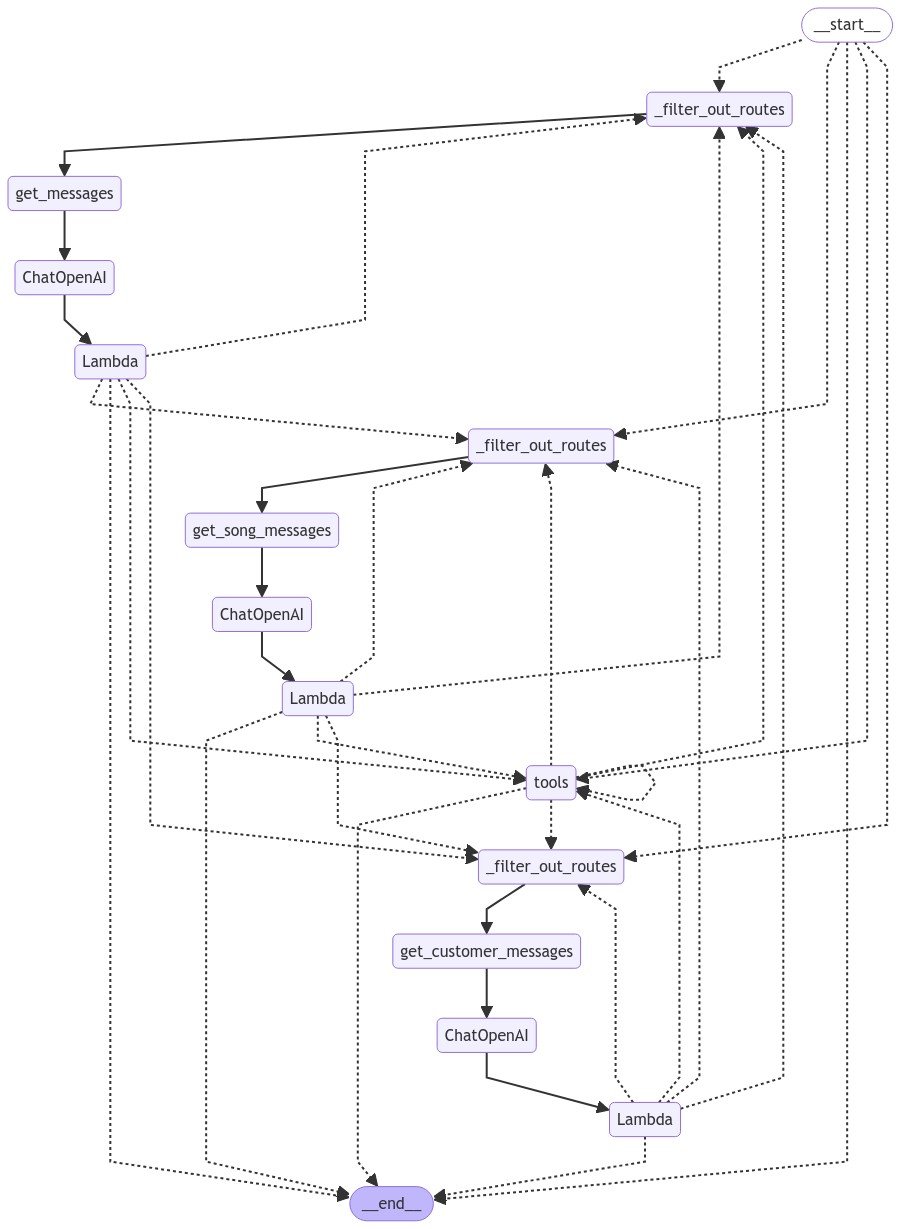

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
import uuid

from langchain_core.messages import HumanMessage

from langgraph.graph.graph import START

history = []
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    history.append(HumanMessage(content=user))
    async for output in graph.astream(history):
        for key, value in output.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")

User (q/Q to quit): hi! can you help me find songs by amy whinehouse?
Output from node 'general':
---
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_dmZKBorVeKFCKSpu7HdrgmdU', 'function': {'arguments': '{"choice":"music"}', 'name': 'Router'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a'} name='general' id='run-553851a5-0e04-4391-8b7e-aff103f0a172-0' tool_calls=[{'name': 'Router', 'args': {'choice': 'music'}, 'id': 'call_dmZKBorVeKFCKSpu7HdrgmdU', 'type': 'tool_call'}]

---

Output from node 'music':
---
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_jMRAcLIVfvtREFjlaHBZt26S', 'function': {'arguments': '{"artist":"amy whinehouse"}', 'name': 'get_tracks_by_artist'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a'} name='music' id='run-0bcb